In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import hmean, norm

In [2]:
from nltk import word_tokenize
from collections import Counter
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

In [3]:
#from pylab import arange, argsort, loglog, title, xlabel, ylabel, grid, logspace, log10
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from statistics import harmonic_mean

In [5]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [7]:
data= load_dataset("imdb", split= "test")

Reusing dataset imdb (/home/sasha/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


In [8]:
datadf = pd.json_normalize(data)

#### Looking at the top rows

In [9]:
datadf.head()

,text,label
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1


#### Getting more information

In [10]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


#### Checking for missing values

In [11]:
datadf[datadf.isnull().any(axis=1)].head()

,text,label


In [12]:
np.sum(datadf.isnull().any(axis=1))

0

#### Count vocab size + frequencies

In [13]:
cvec = CountVectorizer()
cvec.fit(datadf.text)

CountVectorizer()

In [14]:
len(cvec.get_feature_names())

73822

In [15]:
document_matrix = cvec.transform(datadf.text)

In [16]:
datadf[datadf.label == 0].tail()

,text,label
24995,I occasionally let my kids watch this garbage ...,0
24996,When all we have anymore is pretty much realit...,0
24997,The basic genre is a thriller intercut with an...,0
24998,Four things intrigued me as to this film - fir...,0
24999,David Bryce's comments nearby are exceptionall...,0


In [17]:
#Code from https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913

In [18]:
%%time
neg_batches = np.linspace(12500,24999,100).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(neg_batches)-2):
        print(neg_batches[i+1],"entries' term frequency calculated")
    i += 1

12626 entries' term frequency calculated
13888 entries' term frequency calculated
15151 entries' term frequency calculated
16413 entries' term frequency calculated
17676 entries' term frequency calculated
18938 entries' term frequency calculated
20201 entries' term frequency calculated
21463 entries' term frequency calculated
22726 entries' term frequency calculated
23988 entries' term frequency calculated
24999 entries' term frequency calculated
CPU times: user 1.38 s, sys: 1.46 s, total: 2.85 s
Wall time: 2.84 s


In [19]:
datadf[datadf.label == 1].tail()

,text,label
12495,I was extraordinarily impressed by this film. ...,1
12496,"Although I'm not a golf fan, I attended a snea...",1
12497,"From the start of ""The Edge Of Love"", the view...",1
12498,"This movie, with all its complexity and subtle...",1
12499,I've seen this story before but my kids haven'...,1


In [20]:
%%time
pos_batches = np.linspace(0,12499,100).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(pos_batches)-2):
        print(pos_batches[i+1],"entries' term frequency calculated")
    i += 1

126 entries' term frequency calculated
1388 entries' term frequency calculated
2651 entries' term frequency calculated
3913 entries' term frequency calculated
5176 entries' term frequency calculated
6438 entries' term frequency calculated
7701 entries' term frequency calculated
8963 entries' term frequency calculated
10226 entries' term frequency calculated
11488 entries' term frequency calculated
12499 entries' term frequency calculated
CPU times: user 1.27 s, sys: 1.5 s, total: 2.77 s
Wall time: 2.76 s


In [21]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df.head()

,0,1
00,54,61
000,172,147
00000000000,2,0
00000001,1,0
000dm,1,0


In [22]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:25]

,negative,positive,total
the,163291,167923,331214
and,73393,86879,160272
of,68291,75245,143536
to,67823,64567,132390
is,49158,54580,103738
br,51361,48719,100080
it,47328,47058,94386
in,43767,49027,92794
this,40428,34558,74986
that,36640,33947,70587


In [23]:
#Code from https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-3-zipfs-law-data-visualisation-fc9eadda71e7

In [24]:
term_freq_df.shape

(73822, 3)

#### Zipf's law calculations

##### I tried running it on all tokens, but it makes my computer crash...

Text(0.5, 1.0, "Top 500 tokens in IMDB reviews, with Zipf's law in dotted red")

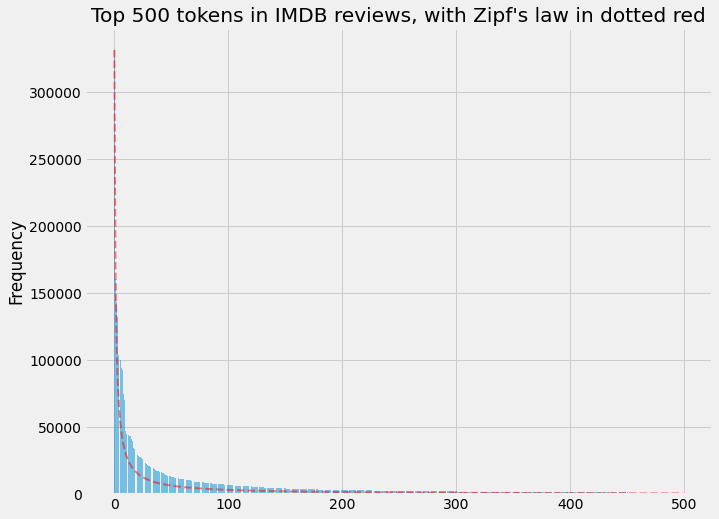

In [25]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title("Top 500 tokens in IMDB reviews, with Zipf's law in dotted red")

### Checking which words do not respect Zipf's law

In [26]:
terms = pd.DataFrame(term_freq_df.sort_values(by='total', ascending=False)['total'][:500])
terms['zipf'] = [int(z) for z in expected_zipf]

In [27]:
terms.head()

,total,zipf
the,331214,331214
and,160272,165607
of,143536,110404
to,132390,82803
is,103738,66242


In [28]:
def check_Zipf(count,zipf):
        return((count-zipf)/zipf * 100)

In [29]:
terms['difference'] = terms.apply(lambda x: check_Zipf(x['total'], x['zipf']), axis=1)

In [30]:
terms['difference'].describe()

count    500.000000
mean      93.366456
std       12.152500
min       -3.221482
25%       87.145154
50%       91.612956
75%       98.966246
max      124.134683
Name: difference, dtype: float64

In [31]:
terms.loc[(terms['difference'] >=100)]

,total,zipf,difference
in,92794,41401,124.134683
this,74986,36801,103.760767
that,70587,33121,113.118565
film,39543,19483,102.961556
one,26806,13248,102.339976
...,...,...,...
going,4088,2031,101.280158
find,4087,2019,102.426944
nothing,4083,2007,103.437967
same,4043,1995,102.656642


So here we can say that 114/500 of the most common words are significantly (?) different from their predicted frequencies according to Zipf's law?

### Checking open versus closed class words

In [33]:
wordlist=open('../resources/closed_EN.txt', 'r').readlines()

In [34]:
closedlist=[]
for l in wordlist:
    closedlist= closedlist + (l.split())
print(len(closedlist))

312


In [35]:
terms.shape

(500, 3)

In [36]:
closedclass= terms[terms.index.isin(closedlist)]
closedclass.shape

(141, 3)

In [51]:
closedclass.loc[(closedclass['difference'] >=100)].sort_values(by='difference', ascending=False).head(10)

,total,zipf,difference
in,92794,41401,124.134683
first,8518,3851,121.189301
most,8591,3896,120.508214
because,8668,3943,119.832615
him,8709,3990,118.270677
where,6299,2905,116.833046
too,7549,3486,116.551922
into,8736,4039,116.291161
did,6327,2931,115.864893
little,5997,2783,115.486885


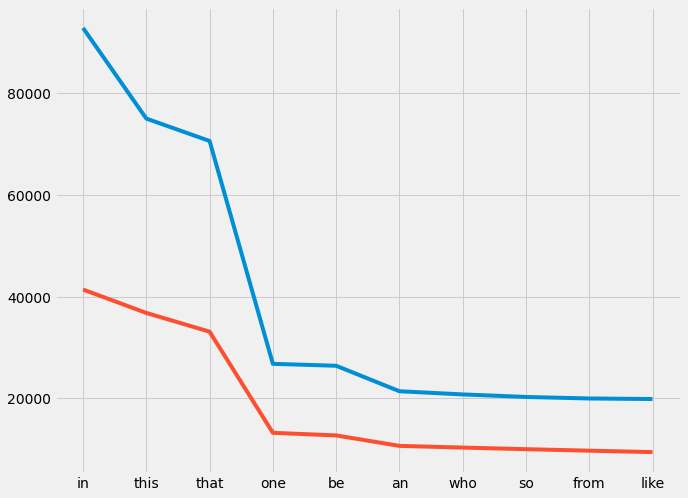

In [70]:
plt.figure(figsize=(10,8))
plt.plot(closedclass[['total','zipf']].loc[(closedclass['difference'] >=100)].sort_values(by='total', ascending=False).head(10))

In [39]:
openclass= terms[~terms.index.isin(closedlist)]
openclass.shape

(359, 3)

In [40]:
openclass['difference'].describe()

count    359.000000
mean      91.647880
std        8.438943
min       72.384018
25%       86.658864
50%       90.636704
75%       95.141273
max      118.194444
Name: difference, dtype: float64

In [62]:
openclass.loc[(openclass['difference'] >=100)].sort_values(by='total', ascending=False).head(10)

,total,zipf,difference
film,39543,19483,102.961556
good,14606,7200,102.861111
very,13658,6624,106.189614
time,12382,6022,105.612753
even,12216,5914,106.560703
see,11550,5710,102.276708
really,11354,5520,105.688406
only,11321,5342,111.924373
story,11129,5257,111.698687
well,10598,5018,111.199681


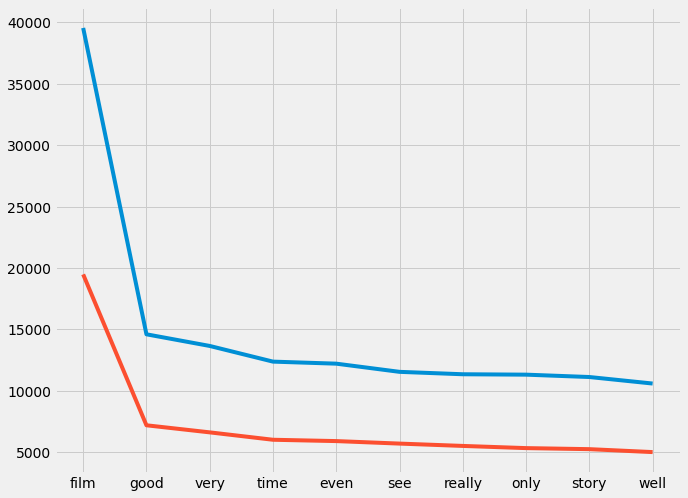

In [68]:
plt.figure(figsize=(10,8))
plt.plot(openclass[['total','zipf']].loc[(openclass['difference'] >=100)].sort_values(by='total', ascending=False).head(10))

### Calculating average fit of Zipf's law (not sure this makes sense, but hey)

See: https://stats.stackexchange.com/questions/180793/how-to-verify-if-data-follows-zipfs-law-without-looking-at-the-graph/180810#180810

In [106]:
def neg_zipf_likelihood(s):
    counter_of_words = Counter(word_tokenize(str(' '.join([d for d in datadf.text.values]))))
    counter_of_counts = Counter(counter_of_words.values())
    word_counts = np.array(list(counter_of_counts.keys()))
    freq_of_word_counts = np.array(list(counter_of_counts.values()))
    n = sum(freq_of_word_counts)
    # for each word count, find the probability that a random word has such word count
    probas = word_counts ** (-s) / np.sum(np.arange(1, n+1) **(-s))
    log_likelihood = sum(np.log(probas) * word_counts)
    return -log_likelihood

In [107]:
#from https://stats.stackexchange.com/questions/331219/characterizing-fitting-word-count-data-into-zipf-power-law-lognormal
s_best = minimize_scalar(neg_zipf_likelihood, [0.1, 3.0] )
print(s_best.x)

0.3990775338344635


#### This is currently giving weird results:

In [ ]:
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = np.arange(1, len(counts)+1)
indices = np.argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
plt.loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
plt.title("Zipf plot for review tokens")
plt.xlabel("Frequency rank of token")
plt.ylabel("Absolute frequency of token")
plt.grid(True)
for n in list(np.logspace(-0.5, np.log10(len(counts)-2), 25).astype(int)):
    dummy = plt.text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

In [ ]:
datadf[datadf['text'].str.contains("ruptures")]

In [ ]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

In [ ]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative reviews')

### I honestly don't know if any of the stuff below is really useful

#### Maybe to show which words only appear in certain labels? (e.g. "kurds" seems to only appear in positive reviews in this dataset)

In [ ]:
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

In [ ]:
for t in datadf.text[datadf['text'].str.contains("Kurds")]:
    print(t)

In [ ]:
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

In [ ]:
term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (harmonic_mean([x['pos_rate'], x['pos_freq_pct']])                                                               if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)
                                                       
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

In [ ]:
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

In [ ]:
np.sum(term_freq_df2.isnull().any(axis=1))

In [ ]:
term_freq_df2.dropna(inplace=True)

In [ ]:
term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

In [ ]:
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])                                                                if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0                                                                else 0), axis=1)
                                                       
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])
term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

In [ ]:
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)